### This python notebook complements the report document (Capstone Report by SBaek.docx) and shows data analysis and calculation following the same numeric order of document sections

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

/Users/seungjinbaek/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/seungjinbaek/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Project roadmap (old)
1. Loading data/clean up
2. Dimensional Reduction (Principal Component Analysis)
3. Clustering Analysis
4. Classification model using Decision Tree
5. Model prediction for unknown dataset

# Project roadmap
1. Definition
2. Analysis
3. Methodology
4. Results
5. Conclusion

----

# Section 1. Definition

Please see the report document for the project overview and problem statement. 

# Section 2. Analysis

## Data Exploration

### 1-1. Import data/data clean up

* Among 10 features (except id number), I have decided perform feature selection where all the ratings informations were removed and time_on_site and listing features were combined as 'listing_per_day'
* Since some users began to sell on the first day they install the app, 'time_on_site' can be zero when there are number of listings recorded. In these cases, listing/time_on_site will generate 'Inf.' In order to avoid Inf happening, I have added 1 to all entries of 'time_on_site.' 

In [2]:
input_file = "data/Customer_activity.csv"
df = pd.read_csv(input_file, header = 0)
df2 = df.drop('install_date',axis=1)

# Create 'listing per day' data column
df2['listing_per_day'] = 0
df2['listing_per_day'][df2['time_on_site']>0] = df2['listing'][df2['time_on_site']>0]/(df2['time_on_site'][df2['time_on_site']>0])

/Users/seungjinbaek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
# see all features
df2.head()

,id,time_on_site,positive_rating,neutral_rating,negative_rating,listing,listing_gmv,sale,buyers,gmv,listing_per_day
0,100000126,27,0,0,0,0,0.0,0,0,0.0,0.000000
1,100000329,5,0,0,0,0,0.0,0,0,0.0,0.000000
2,100002348,76,1,0,0,1,10.0,1,1,10.0,0.013158
3,100002548,5,0,0,0,40,357.0,0,0,0.0,8.000000
4,100003707,23,0,0,0,0,0.0,0,0,0.0,0.000000


### 1-2. Separate users with no selling item
* This users are assumed to be 'New seller' without much analysis or they could be just new users or simply be buyers.
* Only a small fraction of total users have items on sale

In [4]:
dfa = df2[df2['listing']>0]  # data active
dfi = df2[df2['listing']==0] # data inactive

print "* Only %.2f%% of the listed users has items on sale!" % (float(len(dfa))/float(len(df2))*100)
print "* => %.0f users out of total %.0f users have sold at least one item using the app." \
% (float(len(dfa)), float(len(df2)))

* Only 8.07% of the listed users has items on sale!
* => 97423 users out of total 1207774 users have sold at least one item using the app.


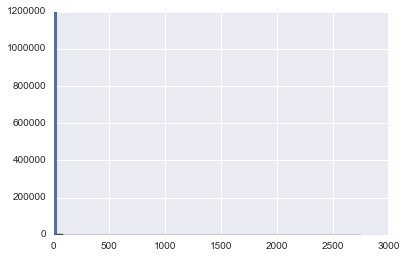

In [5]:
df2['listing'].hist(bins = 100)

# This is useless!!

### 1-3. Basic statistics of the active users (8.07% of total sellers)
* distributions of the sellers by using 'sale' or 'listing'

* use seaborn for faceted histograms

In [6]:
# dfa: active user data
dfa.head()

,id,time_on_site,positive_rating,neutral_rating,negative_rating,listing,listing_gmv,sale,buyers,gmv,listing_per_day
2,100002348,76,1,0,0,1,10.0,1,1,10.0,0.013158
3,100002548,5,0,0,0,40,357.0,0,0,0.0,8.000000
25,100022372,26,0,0,0,9,250.0,0,0,0.0,0.346154
27,100023493,2,0,0,0,2,50.0,0,0,0.0,1.000000
42,100033232,57,0,0,0,9,143.0,1,1,25.0,0.157895


In [7]:
dfa[['time_on_site','listing']].head()

,time_on_site,listing
2,76,1
3,5,40
25,26,9
27,2,2
42,57,9


In [8]:
## dff : data frame final - datasets after feature selection

dff = dfa.iloc[:,[2,3,4,6,7,8,9,10]]

In [9]:
dff['listing_per_day'].describe()

count    97423.000000
mean         0.468860
std          1.504483
min          0.000000
25%          0.037037
50%          0.111111
75%          0.375000
max         89.111111
Name: listing_per_day, dtype: float64

## sort sellers with ratings higher, lower etc.

### compare revenue from users with ratings (pos, neu, neg) and no ratings

### * users with non-zero rating

In [10]:
df_rating= dff[(dff[['positive_rating','neutral_rating','negative_rating']]>0).any(1)]

### * users with non-zero rating

In [11]:
df_NOrating= dff[(dff[['positive_rating','neutral_rating','negative_rating']]==0).all(1)]

##### sanity check for users with/without ratings

In [12]:
len(df_rating)+len(df_NOrating)

97423

-------------------

In [13]:
dtemp = dfa.listing
dtemp2 = dfa.listing[dfa.listing < 100]

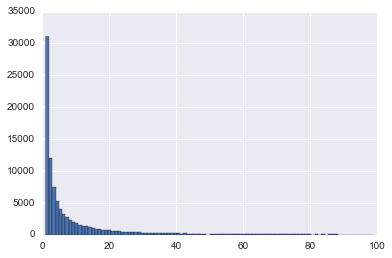

In [14]:
# listing 이 100 보다 작은 유저들의 히스토그램

#n, bins, patches = plt.hist(df_active.listing[df_active.listing<100],100)
#plt.hist()
#n, bins, patches = plt.hist(qq,100)
dfa['listing'][dfa['listing']<100].hist(bins = 100)

### Most of the sellers are the ones with number of selling items less than 20 or maybe 5. This is very skewed data. The revenue distribution, however, could be different from the number of listing.

/Users/seungjinbaek/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


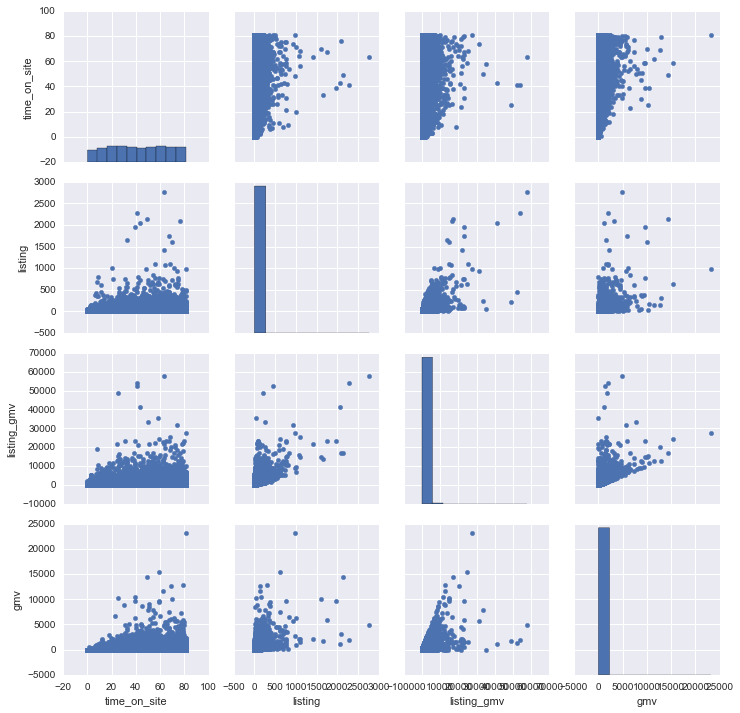

In [15]:
g = sns.PairGrid(dfa[['time_on_site','listing','listing_gmv','gmv']])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

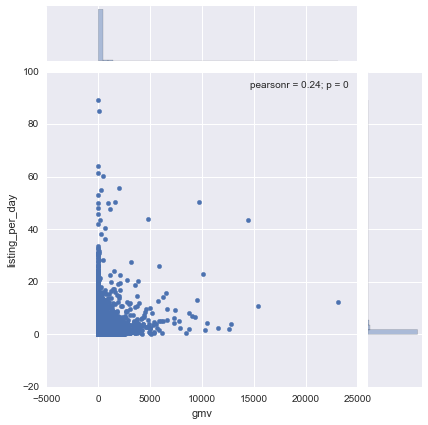

In [16]:
sns.jointplot(dff.gmv, dff.listing_per_day)

### Maybe apply log function to values and plot???

### 1-4. Further data clean-up
* Done in previous section: 'dff' is the final dataset to process

* Plot 'listing' vs 'sale'

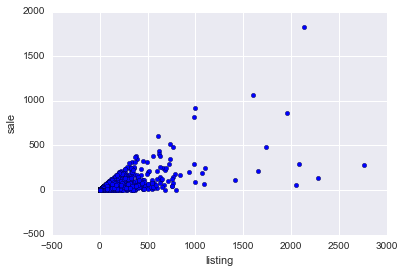

In [17]:
plt.scatter(dfa['listing'],dfa['sale'])
plt.xlabel('listing')
plt.ylabel('sale')

This is obvious, because sale # cannot exceed listing; all data points are shown below 45 degree line.

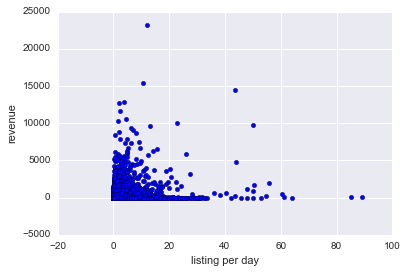

In [18]:
plt.scatter(dff['listing_per_day'],dfa['gmv'])
plt.xlabel('listing per day')
plt.ylabel('revenue')

When the revenue is compared with daily listing, clear correlation is hard to be seen.

> # 7/11/2016
> # Flash idea: using descision tree classifier to segregate sellers?

# 2. Dimensional Reduction
#### Total 8 features reduced to ?? features

In [19]:
dff.head()

,positive_rating,neutral_rating,negative_rating,listing_gmv,sale,buyers,gmv,listing_per_day
2,1,0,0,10.0,1,1,10.0,0.013158
3,0,0,0,357.0,0,0,0.0,8.000000
25,0,0,0,250.0,0,0,0.0,0.346154
27,0,0,0,50.0,0,0,0.0,1.000000
42,0,0,0,143.0,1,1,25.0,0.157895


## 2-1. feature scaling
* Normalize each column before applying principal component analysis

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
dff.describe()

,positive_rating,neutral_rating,negative_rating,listing_gmv,sale,buyers,gmv,listing_per_day
count,97423.000000,97423.000000,97423.000000,97423.000000,97423.000000,97423.000000,97423.000000,97423.000000
mean,2.387578,0.164581,0.036449,379.208462,2.699937,2.576353,67.179198,0.468860
std,11.463812,1.150350,0.366551,942.643014,13.607197,12.469444,278.430278,1.504483
min,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.037037
50%,0.000000,0.000000,0.000000,149.000000,0.000000,0.000000,0.000000,0.111111
75%,1.000000,0.000000,0.000000,375.000000,2.000000,2.000000,42.000000,0.375000
max,1430.000000,164.000000,57.000000,57706.000000,1826.000000,1595.000000,23175.000000,89.111111


In [22]:
scaler = MinMaxScaler()

# scaled data
dfs = pd.DataFrame(scaler.fit_transform(dff), columns = dff.columns)

# all columns are now 'scaled'
dfs.head()

,positive_rating,neutral_rating,negative_rating,listing_gmv,sale,buyers,gmv,listing_per_day
0,0.000699,0.0,0.0,0.000121,0.000548,0.000627,0.000431,0.000148
1,0.000000,0.0,0.0,0.006135,0.000000,0.000000,0.000000,0.089776
2,0.000000,0.0,0.0,0.004281,0.000000,0.000000,0.000000,0.003885
3,0.000000,0.0,0.0,0.000815,0.000000,0.000000,0.000000,0.011222
4,0.000000,0.0,0.0,0.002426,0.000548,0.000627,0.001079,0.001772


## 2-2. PCA

* I have excluded all ratings features (positive, neutral, negative) because most of the ratings are on positive side and only a few negative/neutral ones. 
* Instead of including all three ratings separately, I think it'd be better to combine all into one scalable variable such as rating stars in Netflix or Amazon ratings. This process, however, was skipped for this study.

### 2-2-1 include only a few features  (ratings NOT included)

In [23]:
from sklearn.decomposition import PCA
import renders as rs

pca = PCA().fit(dfs.iloc[:,3:])  # including columns ['listing_gmv' ~ 'listing_per_day']
print pca.explained_variance_ratio_

[  5.98187649e-01   2.36452149e-01   1.29020186e-01   3.61139428e-02
   2.26073134e-04]


### 2-2-2 include all features and let PCA handles the rest

In [24]:
from sklearn.decomposition import PCA
pca_all = PCA().fit(dfs)  # including columns ['listing_gmv' ~ 'listing_per_day']
print pca_all.explained_variance_ratio_

[  5.67652802e-01   2.14000204e-01   1.44869071e-01   4.58475152e-02
   1.81139443e-02   9.07716579e-03   3.57220851e-04   8.20768457e-05]


### Based on the PCA (using all features), top three dimensions were selected and the feature dimension is now reduced to 3.

In [25]:
dfs.head()

,positive_rating,neutral_rating,negative_rating,listing_gmv,sale,buyers,gmv,listing_per_day
0,0.000699,0.0,0.0,0.000121,0.000548,0.000627,0.000431,0.000148
1,0.000000,0.0,0.0,0.006135,0.000000,0.000000,0.000000,0.089776
2,0.000000,0.0,0.0,0.004281,0.000000,0.000000,0.000000,0.003885
3,0.000000,0.0,0.0,0.000815,0.000000,0.000000,0.000000,0.011222
4,0.000000,0.0,0.0,0.002426,0.000548,0.000627,0.001079,0.001772


## Testing PCA with same number of original features (8 features)

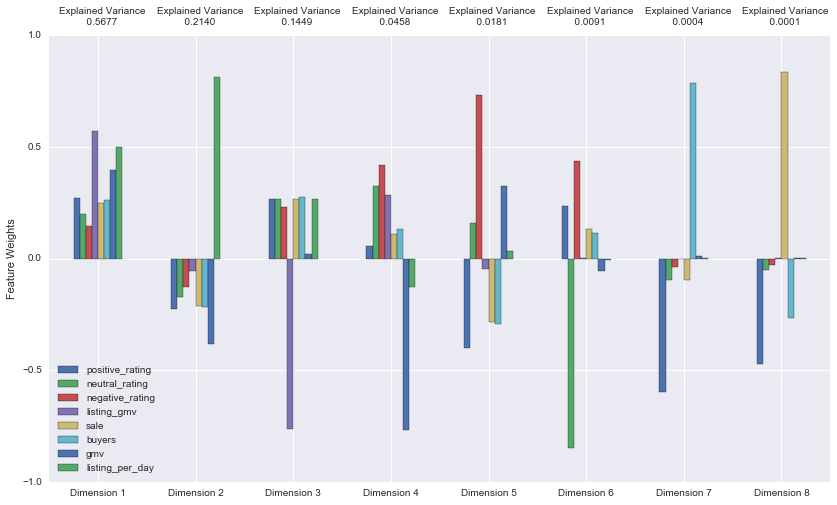

In [26]:
pca8 = PCA(n_components=8)
pca8.fit(dfs)  # dfs: scaled dff

reduced8 = pca8.transform(dfs)  # df_reduced: change variable names

#dfr8.shape
pca8_results = rs.pca_results(dfs,pca8)

## Must select first FIVE dimension to maintain 99% of all variances in data

In [27]:
pca5 = PCA(n_components=5).fit(dfs)
reduced5 = pca5.transform(dfs)  # df_reduced: change variable names

reduced5.shape

(97423, 5)

## Visualize feature distributions
To get a better understanding of the dataset, I construct a scatter matrix of each of the data features present in the data. 

In [28]:
# pd.scatter_matrix(dff, alpha = 0.3, figsize = (16,10), diagonal = 'kde');

# - use 'normalized' dataset

# pd.scatter_matrix(dfs, alpha = 0.3, figsize = (16,10), diagonal = 'kde');

# 3. Clustering Analysis

## 3-1. Assumption

#### I previously assumed that the sellers with no listing were categorized as 'new seller,' therefore the remaining 'active' sellers will need to be segmented into THREE groups.
1. Casual seller
2. Business seller
3. Top seller

> # 7/11/2016, 9/11/2016
> # For this project, we don't assume n = 3. Try multiple n and then compute silhouette coefficient value

> # And not just Kmeans clustering, but try other classifiers too.

#### After PCA, clustering analysis does not label the data, but rather segregates into group (in this case, three) purely based on the data; it's up to a human modeler to label them later, meaningfully.

## 3-2. Clustering

### 3-2-1. K-means clustering

### with sample_size = 20000

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

input_data = reduced5
row_selections = np.random.randint(len(input_data),size=20000)

for n in range(2,7):
    startT = time.time()

    clusterer = KMeans(init = 'k-means++', n_clusters=n, n_init=10, max_iter = 500, 
                       random_state= 200)
    
    clusterer.fit(reduced5)
    cluster_labels = clusterer.fit_predict(input_data)
    
    
    startT = time.time()
    silhouette_avg = silhouette_score(input_data[row_selections,:],
                                  cluster_labels[row_selections])
    sample_silhouette_values = silhouette_samples(input_data[row_selections,:], 
                                              cluster_labels[row_selections])
    endT = time.time()
    print 'numer of clustering is',n,': silhouette score is',silhouette_avg
    print "elapsed time %.2f" % (endT-startT)


numer of clustering is 2 : silhouette score is 0.897870311
elapsed time 111.36
numer of clustering is 3 : silhouette score is 0.851121258397
elapsed time 110.13


KeyboardInterrupt: 

## TESTING plot when n = 3

In [ ]:
input_data = reduced5
row_selections = np.random.randint(len(input_data),size=30000)

# number of clusters
n = 3

clusterer = KMeans(init = 'k-means++', n_clusters=n, n_init=10, max_iter = 500, 
                   random_state= 200)

clusterer.fit(reduced5)
cluster_labels = clusterer.fit_predict(input_data)

startT = time.time()
silhouette_avg = silhouette_score(input_data[row_selections,:],
                              cluster_labels[row_selections])
sample_silhouette_values = silhouette_samples(input_data[row_selections,:], 
                                          cluster_labels[row_selections])
endT = time.time()
print 'numer of clustering is',n,': silhouette score is',silhouette_avg
print "elapsed time %.2f" % (endT-startT)

## TESTING plot!

2064
20
4
276
48


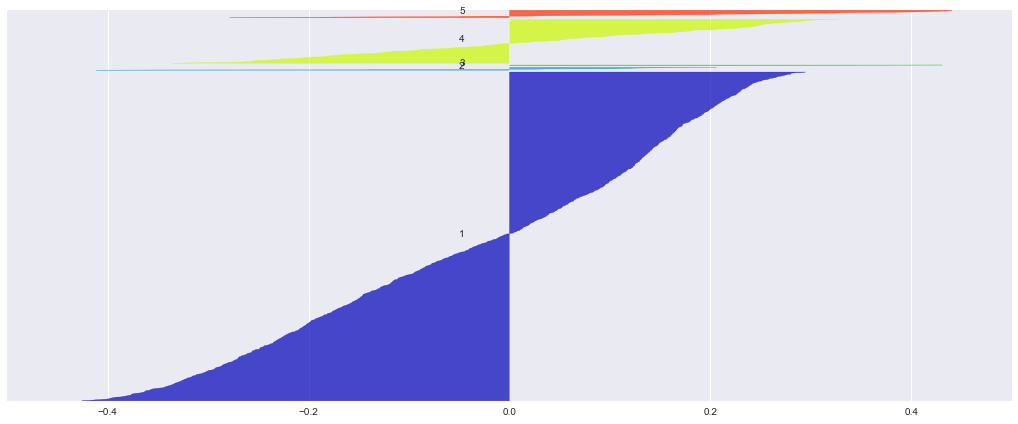

In [30]:
y_lower = 10
nn_cluster = 6

#fig, (ax1,ax2) = plt.subplots(1,2)
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18,7)

# for i in range(1,nn_cluster):
for i in range(0,nn_cluster):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels[row_selections] == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.spectral(float(i)/nn_cluster)
    ax1.fill_betweenx(np.arange(y_lower,y_upper), 0,
                     ith_cluster_silhouette_values,
                     facecolor = color, edgecolor = color, alpha = 0.7)
    ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
    y_lower = y_upper + 10
    ax1.set_yticks([])
    print size_cluster_i

# 9/14/2016: wrap here

--------

### 3-2-1. DBSCAN clustering

As seen in the figure and number of users in each clusters, clusters are not evenly distributed and one or two clusters contain most of the datasets.

In the next subsection, I tried a different clustering algorighm of DBSCAN, which views clusters as areas of high density separated by areas of low density. It is known that the clusters found using DBSCAN can be any shape, whereas k-means assumes the clusters to be convex shapes. Having negative silhouette scores in may smaller clusters found using k-means may indicate that the ground truth clusters may not be convex shapes.

In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3, min_samples = 10).fit(input_data)

# 9/15/2016: wrap here

--------

--------

## 3-3. Data Labeling with group numbers

* Merge the labeled data for 'active sellers' to the original data frame

In [ ]:
dfa['cluster'] = cl_labels

In [ ]:
df_clustered = pd.merge(df, df_active[['id','cluster']],on='id',how='left')

* Add 3 to the 'new seller' group

In [ ]:
df_clusteredAll = df_clustered.fillna(3)

### Labeling based on average listings per each group

In [ ]:
group_listing = df_clusteredAll['listing'].groupby(df_clusteredAll['cluster'])
group_listing.mean()

### As shown above, the average listings per each labeled group were computed. It is now possible to determine which group belongs to which predefined seller groups.


* Group 0: casual seller (avg 8.1 listings)
* Group 1: business seller (avg 89.6 listings)
* Group 2: top seller (avg 498.8 listings)
* Group 3: new seller (none listed)

## 3-4. Export to csv file

In [ ]:
df_clusteredAll.to_csv('All_data_clustered.csv')
df_clusteredAll[df_clusteredAll['cluster']==0].to_csv('data_casual_seller.csv')
df_clusteredAll[df_clusteredAll['cluster']==1].to_csv('data_business_seller.csv')
df_clusteredAll[df_clusteredAll['cluster']==2].to_csv('data_top_seller.csv')
df_clusteredAll[df_clusteredAll['cluster']==3].to_csv('data_new_seller.csv')


# 4. Classification model using Decision Tree

* Now the clustering the seller is done. 
* Based on the seller segregation done in the previous step, we may be able to predict which group a unknown seller belongs when features of the seller are known.
* I used Decision Tree classifier to train the model.

## 4-1. splitting data into train/test sets

In [ ]:
# separate the data into 'Features' and 'Labels' (or 'groups')
# And then, split them into 70-30 ratio for training and testing datasets

model_features = df_clusteredAll[['listing','listing_gmv','sale','buyers','gmv']]
model_groups = df_clusteredAll['cluster']

from sklearn.cross_validation import train_test_split
def shuffle_split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=42)
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = shuffle_split_data(model_features, model_groups)

## 4-2. Define performance metrics

In [ ]:
from sklearn.metrics import mean_squared_error
def performance_metric(y_true, y_predict):
    error = mean_squared_error(y_true, y_predict)
    return error

## 4-3. Train the model

#### Here I present two different decision tree models. I should have chosen the better model, but it is notable to present both of them because this might cast some question in quality of the model fit.


#### Initially, the model was calibrated only with 'min_samples_split' variable (model 1), which defines the minimum number of samples required to split an internal node, but later also tweaked 'max_depth' (maximum depth of the tree) (model 2).

### Findings
#### I used scikit-learns cross validation and grid search tools and tested various numbers for these parameters and found out that when min_samples_split is the only variable, min_samples_split = 100 would be the optimal parameter for the model
#### However, when 'max_depth' was also used in grid search function, then the optimal min_sample_split is 10. As seen in the figure below, this value of 10 would most likely suffer from the high bias problem (underfitting).
#### Based on the findings here, it seems 'max_depth' is more sensitive in fitting the decision tree then 'min_sample_split' variable.

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# first model with only 'min_samples_split' calibrated

def fit_model(X,y):
    # desicion tree classifier object
    clf = DecisionTreeClassifier()
    
    # parameters to use for tuning
    parameters ={'min_samples_split':(10, 50, 100, 5000)}
    
    # some scoring function
    scoring_function = make_scorer(mean_squared_error, greater_is_better = False)
    
    # grid search
    classi = GridSearchCV(clf, param_grid = parameters, scoring=scoring_function)
    classi.fit(X,y)
    
    return classi.best_estimator_

# -----------------------------------------------------------------------------
# second model with 'min_samples_split' and 'max_depth' calibrated

def fit_model2(X,y):
    # desicion tree classifier object
    clf = DecisionTreeClassifier()
    
    # parameters to use for tuning
    parameters ={'min_samples_split':(10, 50, 100, 5000),'max_depth':(1,3,5,7,9)}
    
    # some scoring function
    scoring_function = make_scorer(mean_squared_error, greater_is_better = False)
    
    # grid search
    classi2 = GridSearchCV(clf, param_grid = parameters, scoring=scoring_function)
    classi2.fit(X,y)
    
    return classi2.best_estimator_

classi = fit_model(model_features, model_groups)
classi2 = fit_model2(model_features, model_groups)

## 4-4. Learning Curve

In [ ]:
def learning_curves(X_train, y_train, X_test, y_test):
    
    # Create the figure window
    fig = plt.figure(figsize=(10,8))

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.rint(np.linspace(1, len(X_train), 100)).astype(int)
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    # Create four different models based on max_depth
    # for k, depth in enumerate([1,3,6,10]):
    for k, split in enumerate([10, 50, 100, 5000]):
        
        for i, s in enumerate(sizes):
            
            # Setup a decision tree regressor so that it learns a tree with max_depth = depth
            classifier = DecisionTreeClassifier(min_samples_split= split)
            
            # Fit the learner to the training data
            classifier.fit(X_train[:s], y_train[:s])

            # Find the performance on the training set
            train_err[i] = performance_metric(y_train[:s], classifier.predict(X_train[:s]))
            
            # Find the performance on the testing set
            test_err[i] = performance_metric(y_test, classifier.predict(X_test))
            

    
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, test_err, lw = 2, label = 'Testing Error')
        ax.plot(sizes, train_err, lw = 2, label = 'Training Error')
        ax.legend()
        ax.set_title('Minimum split samples = %s'%(split))
        ax.set_xlabel('Number of Data Points in Training Set')
        ax.set_ylabel('Total Error')
        ax.set_xlim([0, len(X_train)])
        ax.set_ylim([0, 0.01])
        
    # Visual aesthetics
    fig.suptitle('Decision Tree Classifier Learning Performances', fontsize=18, y=1.03)
    fig.tight_layout()
    fig.show()

### Learning curve with minimum split samples = 100 looks better than other three.

In [ ]:
learning_curves(X_train,y_train,X_test,y_test)

In [ ]:
def learning_curves(X_train, y_train, X_test, y_test):
    
    
    # Create the figure window
    fig = plt.figure(figsize=(10,8))

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.rint(np.linspace(1, len(X_train), 100)).astype(int)
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    # Create four different models based on max_depth
    for k, depth in enumerate([1,3,5,9]):
    
        
        for i, s in enumerate(sizes):
            
            # Setup a decision tree regressor so that it learns a tree with max_depth = depth
            classifier = DecisionTreeClassifier(max_depth = depth)
            
            # Fit the learner to the training data
            classifier.fit(X_train[:s], y_train[:s])

            # Find the performance on the training set
            train_err[i] = performance_metric(y_train[:s], classifier.predict(X_train[:s]))
            
            # Find the performance on the testing set
            test_err[i] = performance_metric(y_test, classifier.predict(X_test))
            

    
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, test_err, lw = 2, label = 'Testing Error')
        ax.plot(sizes, train_err, lw = 2, label = 'Training Error')
        ax.legend()
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Data Points in Training Set')
        ax.set_ylabel('Total Error')
        ax.set_xlim([0, len(X_train)])
        #ax.set_xlim([0, 200000])
        ax.set_ylim([0, 0.01])
    
    # Visual aesthetics
    fig.suptitle('Decision Tree Classifier Learning Performances', fontsize=18, y=1.03)
    fig.tight_layout()
    fig.show()

### Learning curve with Maximum depth = 9 looks better than other three.

In [ ]:
learning_curves(X_train,y_train,X_test,y_test)

In [ ]:
classi.get_params()


In [ ]:
classi2.get_params()

# 5. Model prediction

## 5-1. Testing model prediction

* See prediction tests below; the last entry is segregated and labeled as group 2 (top seller) in the clustering analysis.
* But, when I tested this seller using the first decision tree model, it was predicted to be in the group 1 (Business seller)!
* Please see the next section for quantitative evaluation of the classifier.

In [ ]:
# features: ['listing','listing_gmv','sale','buyers','gmv']
new_seller = [[0,0,0,0,0]]   # new seller
new_seller = [[100,1000,10,10,100]] # casual
new_seller = [[100,1000,100,100,1000]] # business
new_seller = [[249,8466,174,155,5553]] # top seller
new_seller = [[66,19674,2,2,33]] # top seller or business?


#new_seller = [[0,0,0,0,0]]
new_prediction = classi.predict(new_seller)
new_prediction2 = classi2.predict(new_seller)
print new_prediction, new_prediction2

## 5-2. Quantitative evaluation of the model

* It is shown that the second classifier model (classi2) presents the better F1 score for groups 2 and 3.

In [ ]:
from sklearn.metrics import classification_report

model_prediction = classi.predict(model_features)
print(classification_report(model_groups,model_prediction))

In [ ]:
model_prediction = classi2.predict(model_features)
print(classification_report(model_groups,model_prediction))

# Remarks

* It's been a fun project to analyze the seller datasets with limited available information.

### My take on this project contains two main parts.

#### part 1
* With the given information, I have segregated the sellers into four groups.

#### part 2
* And then assuming this group segregation was correctly done, I trained a decision tree model for prediction on future/unknown sellers.

# Future recommendation
* Different classifier/different sets of calibration parameters would be beneficial to build a more robust model
* Create a scalable user ratings from the existing three distinct ratings (good, neutral, bad)